# Imports e variáveis globais

In [1]:
%%capture
!pip install pandas
!pip install sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print('Tensorflow version {}'.format(tf.__version__))

Tensorflow version 2.1.0


Algumas variáveis globais para auxiliar no fine-tunning sem ter que procurá-las pelo código.

In [3]:
vocab_size = 100
oov_token = '<OOV>'
padding_type = 'post'
trunc_type = 'post'
padding_max_len = 20
embedding_dim = 8
num_epochs = 30

# Manipulação dos dados

In [4]:
data = pd.read_csv('data.csv', sep=';')
data.head()

,url,text,is_birthday
0,https://twitter.com/_LezShipp_/status/12466372...,Como hoje é meu aniversário e estamos de Karao...,1
1,https://twitter.com/Mariazinha8C/status/124663...,Hoje é aniversário de uma pessoa maravilhosa q...,0
2,https://twitter.com/penguinjjk/status/12466371...,hm kk hoje é meu aniversário eu sei ninguém li...,1
3,https://twitter.com/BrSouza7/status/1246637061...,"Aniversário do bê hoje, meu neném está crescen...",0
4,https://twitter.com/LuaC1506/status/1246637017...,Hoje é aniversário de uma das pessoas mais imp...,0


In [5]:
sentences = data['text']
urls = data['url']
is_birthday = data['is_birthday']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    sentences, 
    is_birthday, 
    shuffle=True, 
    random_state=42,
    stratify=is_birthday
)

print("Train set tem {} linhas.\nTest set tem {} linhas.".format(X_train.shape[0], X_test.shape[0]))

Train set tem 224 linhas.
Test set tem 75 linhas.


# Word embeddings

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [8]:
# Train sequences
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=padding_max_len)

# Test sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, padding=padding_type, truncating=trunc_type, maxlen=padding_max_len)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=padding_max_len),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 8)             800       
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 966       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 1,773
Trainable params: 1,773
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test));

Train on 224 samples, validate on 75 samples
Epoch 1/30
224/224 [==============================] - 0s 2ms/sample - loss: 0.6855 - accuracy: 0.6161 - val_loss: 0.6735 - val_accuracy: 0.8533
Epoch 2/30
224/224 [==============================] - 0s 161us/sample - loss: 0.6668 - accuracy: 0.8125 - val_loss: 0.6559 - val_accuracy: 0.8400
Epoch 3/30
224/224 [==============================] - 0s 180us/sample - loss: 0.6476 - accuracy: 0.8170 - val_loss: 0.6372 - val_accuracy: 0.8133
Epoch 4/30
224/224 [==============================] - 0s 148us/sample - loss: 0.6267 - accuracy: 0.8170 - val_loss: 0.6170 - val_accuracy: 0.8133
Epoch 5/30
224/224 [==============================] - 0s 148us/sample - loss: 0.6028 - accuracy: 0.8170 - val_loss: 0.5946 - val_accuracy: 0.8133
Epoch 6/30
224/224 [==============================] - 0s 147us/sample - loss: 0.5754 - accuracy: 0.8170 - val_loss: 0.5702 - val_accuracy: 0.8133
Epoch 7/30
224/224 [==============================] - 0s 156us/sample - loss: 0.5

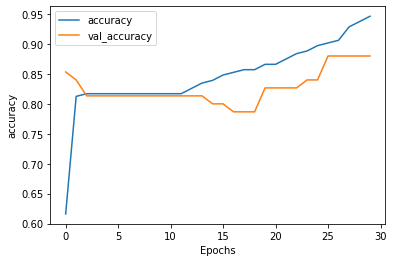

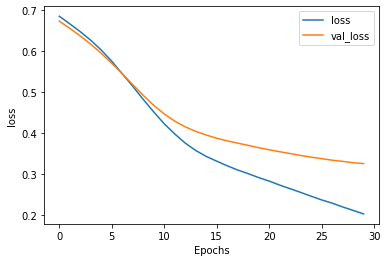

In [11]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Gerando arquivos para visualizar o embedding

O snippet abaixo gera dois arquivos que podem ser visualizados se upados em https://projector.tensorflow.org

*TODO*: implementar `projector` de `tensorboard.plugins`

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, weights.shape[0]):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()